# 521153S, Deep Learning assignment 4: Improvements on Convolutional Neural Networks 



## Outline 
#### In this assignment, you will learn:
* Load training/validation/testing dataset from csv file. 
* Building a Convolutional Neural Network (CNN) in Pytorch.
* Use the resnet-18 Pytorch model.
* Using tensorboard.
* Save and load your model.
* Training and testing your CNN in Pytorch.

#### Tasks (<span style="color:green">15 points or more</span>)
* **Part 1.** Writing a custom dataset based on [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist). Spliting the whole dataset into 3 parts: training, validation and testing. (<span style="color:green">5.0 points</span>)
    * 1.1. Define a Dataset class <br>
    * 1.2. Dataset checking (<span style="color:green">2.0 points</span>) <br>
    * 1.3. Build our custom data augmentation <br>
    * 1.4. Load the training/validation/testing data to Dataloader (<span style="color:green">2.0 points</span>) <br>
    * 1.5. Use functions define in **Part 1.4** to actually create our training/validation/testing DataLoaders (<span style="color:green">1.0 point</span>) <br>
* **Part 2.** Build a CNN on your own. (<span style="color:green">1.0 point</span>) <br>
    * 2.1 Modify model from assignment 3 (<span style="color:green">1.0 point</span>) <br>
    * 2.2 ResNet-18
* **Part 3.** Train and test your CNN model (<span style="color:green">9.0 points or more</span>)
    * 3.1. Create functions for train and evaluation <br>
    * 3.2. Training and tensorboard log  (<span style="color:green">1.5 points</span>) <br>
    * 3.3. Tensorboard visualization  (<span style="color:green">1.0 point</span>) <br>
    * 3.4. Train and test your network (<span style="color:green">1.0 points</span>) <br>
    * 3.5. Train and test using the resnet-18 model (<span style="color:green">2.5 points</span>) <br>
    * 3.6. Load a pretrained weights and report the accuracy from **Assignment_4_load_model.ipynb** (<span style="color:green">3.0 points</span>) <br>
    * 3.7. Ideas on improving the testing accuracy (<span style="color:green">max 2 points</span>) <br>


#### Environment
Python 3, Numpy, matplotlib, torch, torchvision, pandas, tensorboard  
* To install needed Python packages, run:  
**pip install tensorboard pandas future**

#### Dataset
* [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist)
is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Here we are to split the 60,000 images in the predefined training set into a new training set with 50,000 images and a validation set with 10,000 images. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training, validation and testing splits. Using the Fashion-MNIST give you more room to wiggle your experiments.

#### Hints
* To find the place where you have to insert your solution, hit **Crtl + F** and search for **TODO:** . You are <span style="color:red">**NOT**</span> supposed to modify the codes from other parts.
* Be careful with the shapes of the tensors flowing through the CNN model, making all the operations has compatible inputs and outputs. 
* In case your computer support CUDA, you can add .cuda() to your model, loss and data to use your GPU. Refer to our [pytorch tutorial](https://moodle.oulu.fi/pluginfile.php/189345/mod_resource/content/3/Pytorch%20Tutorial%20for%20Deep%20Learning%202019.pdf) to see this.

## Part 1. Write your own custom dataset with Pytorch (<span style="color:green">5 points</span>)
**Requirement**: Download the Fashion-MNIST dataset, which contains 60,000 images in the predefined training set and 10,000 images in the testing set. Our goal is to write our custom dataset. The training/validation/testing data were already split as 50K/10K/10K, respectively. **Specifically, there is the same number of images for each class, both in the new training set and the validation set.** I.e., in the new training set, which has in total 10 classes and 50,000 image samples, each class has 5000 image samples while in the validation set, each class has 1000 samples.
+ In assignment 3, we loaded the whole training + validation + testing data into the memory. This, in turn, can quickly swallow your memory.
+ In practice, we usually load data by batch during training or testing time, which consumes much less memory. In this assignment, our data was structured like this:  
(folder)fashion_mnist_extracted  
---(folder)train_images  
------(folder)Ankle_boot  
---------0000000.png  
---------0000001.png  
------(folder)Bag  
------(folder)Coat  
.  
.  
---(folder)val_images  
------(folder)Ankle_boot  
---------0000000.png  
---------0000001.png  
------(folder)Bag  
------(folder)Coat  
.  
.  
---(folder)test_images  
------(folder)Ankle_boot  
---------0000000.png  
---------0000001.png  
------(folder)Bag  
------(folder)Coat  
.  
.  
---train.csv  
---val.csv  
---test.csv  
that our **.csv files** contains the image paths and their corresponding labels. Their content look like this:  
./fashion_mnist_extracted/train_images/Dress/0000012.png,3  
./fashion_mnist_extracted/train_images/T_shirt/0000006.png,0  
./fashion_mnist_extracted/train_images/Sneaker/0000004.png,7  
./fashion_mnist_extracted/train_images/Trouser/0000003.png,1  
./fashion_mnist_extracted/train_images/Shirt/0000005.png,6  
<span style="color:purple"> ***You should take a look at the data in folder `fashion_mnist_extracted`*** </span>


### Part 1.1. Define a Dataset class
As in previous assignment, torch.utils.data.Dataset is an abstract class representing a dataset. Our **FashionMNISTDataset** dataset should inherit `torch.utils.data.Dataset` and override the following methods:
* `__init__` defines additional attributes for our dataset.
* `__len__` so that len(dataset) returns the size of the dataset.
* `__getitem__` to support the indexing such that dataset[i] can be used to get ith sample


In [5]:
# import necessary packages
import os, time
import torch 
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from utils import download_fm, get_preds_figure
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import random, matplotlib
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.resnet import BasicBlock
import torch.utils.model_zoo as model_zoo

download_fm('./')

# Check does your computer support using GPU
print("GPU_available={}".format(torch.cuda.is_available()))

Data downloaded and extracted!
GPU_available=True


Let’s create a dataset class for our fashion MNIST dataset. We will download the dataset from google drive following Assignment 2 and 3. 
* **FashionMNISTDataset** takes in a csv_file and a compose torchvision.transforms to perform data augmentation.  
* **__getitem__() function** loads a specific data sample, transform and convert it to pytorch tensor and return a dictionary that contains the image and its label.  

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FashionMNISTDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        # Read the csv file
        self.frame = pd.read_csv(csv_file, header=None)
        self.transform = transform
        
        self.label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    def __getitem__(self, idx):
        image_name = self.frame.iloc[idx, 0]
        image = Image.open(image_name)
        
        label = self.frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}

        return sample

    def __len__(self):
        return len(self.frame)

### Part 1.2. Dataset checking (<span style="color:green">2.0 points</span>)
Similar to assignment 3, randomly show some images in training, validation and testing data and check if the images have correct labels. We also check the number of images for each class, to make sure the dataset created correctly.

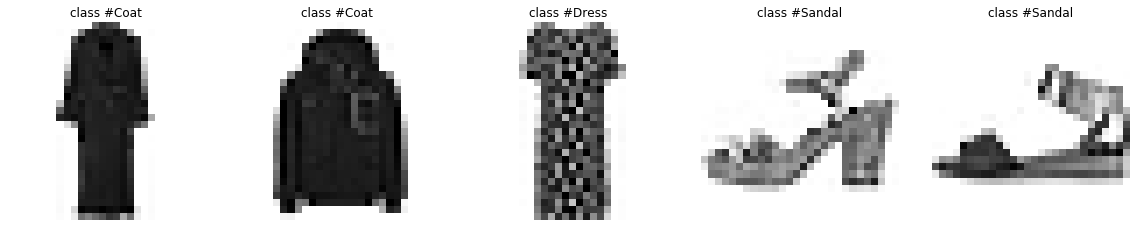

total number of training set: 50000
numer of images for class T-shirt/top: 5000
numer of images for class Trouser: 5000
numer of images for class Pullover: 5000
numer of images for class Dress: 5000
numer of images for class Coat: 5000
numer of images for class Sandal: 5000
numer of images for class Shirt: 5000
numer of images for class Sneaker: 5000
numer of images for class Bag: 5000
numer of images for class Ankle boot: 5000


In [7]:
# Create a train_set from the train.csv file without any transformations
train_set = FashionMNISTDataset(csv_file='./fashion_mnist_extracted/train.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]['image'], train_set[idx[i]]['label']
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# Print the number of total images in the training set
print('total number of training set: {}'.format(len(train_set)))

# Print the number of images per class in the training set
class_num_train = np.zeros(10, dtype=np.int32)
for x in train_set:
    class_num_train[x['label']] += 1
for i in range(10):
    print('numer of images for class {}: {}'.format(train_set.label_names[i], class_num_train[i]))

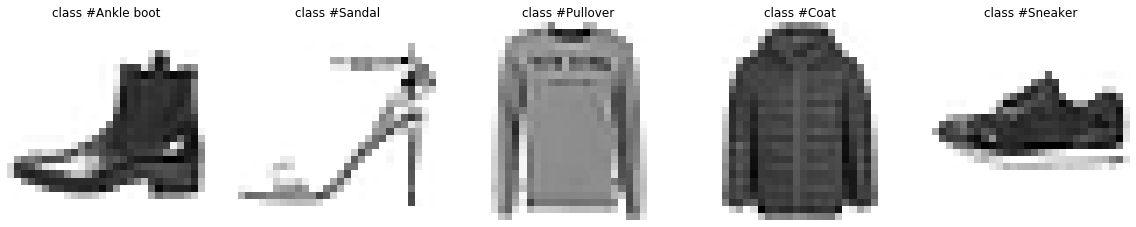

total number of validing set: 10000
numer of images for class T-shirt/top: 1000
numer of images for class Trouser: 1000
numer of images for class Pullover: 1000
numer of images for class Dress: 1000
numer of images for class Coat: 1000
numer of images for class Sandal: 1000
numer of images for class Shirt: 1000
numer of images for class Sneaker: 1000
numer of images for class Bag: 1000
numer of images for class Ankle boot: 1000


In [8]:
# TODO:load and checking validation data (1 point)
# Create a valid_set from the val.csv file without any transformations
valid_set =  FashionMNISTDataset(csv_file='./fashion_mnist_extracted/val.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = valid_set[idx[i]]['image'], valid_set[idx[i]]['label']
    label_name = valid_set.label_names[label]    

    # TODO: show plots
    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# TODO: Print the number of total images in the validation set    
print('total number of validing set: {}'.format(len(valid_set)))

# TODO: Print the number of images per class in the validation set
class_num_val = np.zeros(10, dtype=np.int32)
for x in valid_set:
    class_num_val[x['label']] += 1
for i in range(10):
    print('numer of images for class {}: {}'.format(valid_set.label_names[i], class_num_val[i]))

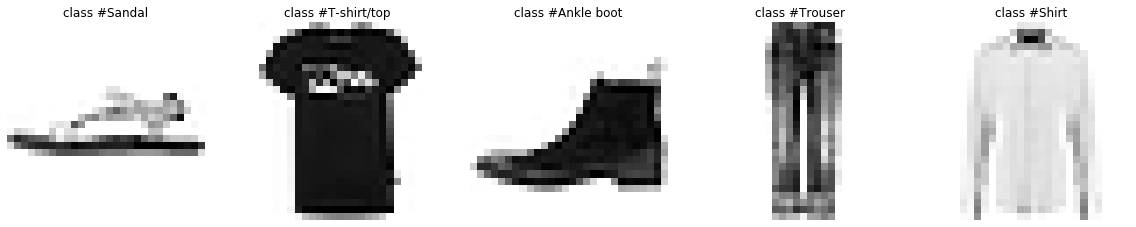

total number of testing set: 10000
numer of images for class T-shirt/top: 1000
numer of images for class Trouser: 1000
numer of images for class Pullover: 1000
numer of images for class Dress: 1000
numer of images for class Coat: 1000
numer of images for class Sandal: 1000
numer of images for class Shirt: 1000
numer of images for class Sneaker: 1000
numer of images for class Bag: 1000
numer of images for class Ankle boot: 1000


In [9]:
# TODO: checking testing data (1 point)
# Create a test_set from the test.csv file without any transformations
test_set =  FashionMNISTDataset(csv_file='./fashion_mnist_extracted/test.csv', transform=None)
num_to_show = 5
idx = np.random.choice(range(len(test_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = test_set[idx[i]]['image'], test_set[idx[i]]['label']
    label_name = test_set.label_names[label]    

    # TODO: show plots
    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# TODO: Print the number of total images in the testing set    
print('total number of testing set: {}'.format(len(test_set)))
    
# TODO: Print the number of images per class in the testing set
class_num_test = np.zeros(10, dtype=np.int32)
for x in test_set:
    class_num_test[x['label']] += 1
for i in range(10):
    print('numer of images for class {}: {}'.format(test_set.label_names[i], class_num_test[i]))


### Part 1.3. Build our custom data augmentation

We can define a custom data transformation for data augmentation namely **RandomWindowDrop**. There are 50%/50% chance that it will randomly cut a square window inside our image or horizontally flip the image.  
* Randomly cut a square window.
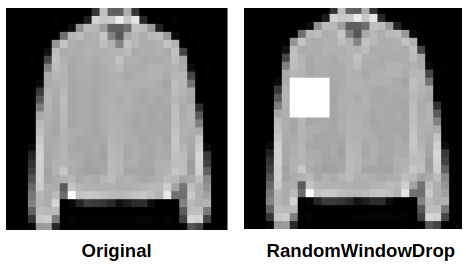
* Random horizontal flip.
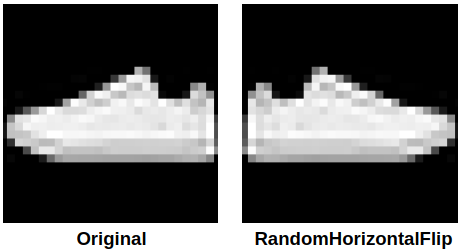
Perform data augmentation during training improve the performance of our model. As we will see later, our model performance will increase from 90% -> 91% when applying **RandomWindowDrop**

In [10]:
class RandomWindowDrop(object):
    def __init__(self, window_size):
        assert isinstance(window_size, (int, tuple))
        if isinstance(window_size, int):
            self.window_size = (window_size, window_size)
        else:
            assert len(window_size) == 2
            self.window_size = window_size
        
        # Define a horizontalFlip
        self.trans = transforms.RandomHorizontalFlip(p=1.0)

    def __call__(self, sample):
        image = sample

        # Perform either RandomWindowDrop or RandomHorizontalFlip
        if random.random() < 0.5:
            h, w = image.size
            imagePixels = image.load()
            top = np.random.randint(self.window_size[0], h - self.window_size[0])
            left = np.random.randint(self.window_size[1], w - self.window_size[1])
            for i in range(top, top+self.window_size[0], 1):
                for j in range(left, left+self.window_size[1], 1):   
                    imagePixels[i, j] = 0
        else:
            image = self.trans(image)

        return image

### Part 1.4. Load the training/validation/testing data to Dataloader (<span style="color:green">2 points</span>)  
Here, we declare functions that use to load our training/validation/testing data using the our defined **FashionMNISTDataset**. 
* To create a DataLoader, we declare functions that will load our files and output DataLoaders. As defined earlier, our **FashionMNISTDataset** takes in a csv_file and a list of transformation to create the Dataset. This Dataset is used to create the DataLoader.
* For training, we will create train_loader using **train.csv** with list of transformations (later you will be askd to insert more transformation in **Part 3.5**)
    * RandomWindowDrop(6)
    * transforms.ToTensor()
    * transforms.Normalize(__normalize_stats['mean'], __normalize_stats['std'])
    
* For validation, we will create valid_loader using **val.csv** with list of transformations (later you will be asked to insert more transformation in **Part 3.5**)
    * transforms.ToTensor()
    * transforms.Normalize(__normalize_stats['mean'], __normalize_stats['std'])
    
* For testing, we will create test_loader using **test.csv** with list of transformations (later you will be asked to insert more transformation in **Part 3.5**)
    * transforms.ToTensor()
    * transforms.Normalize(__normalize_stats['mean'], __normalize_stats['std'])

In [11]:
def getTrainingData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}

    # transforms.Compose create a list of transformations
    transformed_training = FashionMNISTDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            RandomWindowDrop(6),
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))

    dataloader_training = DataLoader(transformed_training, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_training


def getEvalData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    # TODO: Part 1.4 (1 point)
    transformed_eval = FashionMNISTDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            RandomWindowDrop(6),
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_eval = DataLoader(transformed_eval, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_eval

def getTestData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    # TODO: Part 1.4 (1 point)
    transformed_test = FashionMNISTDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            RandomWindowDrop(6),
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_test = DataLoader(transformed_test, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_test

### Part 1.5. Use functions define in **Part 1.4** to actually create our training/validation/testing DataLoaders (<span style="color:green">1 point</span>)  

In assignment 3, to load the images and labels from e.g. train_loader, one would call:  
```
for i, (images, labels) in enumerate(train_loader):
    outs = net(images) 
```
***In this assignment, our DataLoader return a dict, so we should call***
```
for i, sample in enumerate(train_loader):
    images, labels = sample['image'], sample['label']
    outs = net(images)
```  

In [12]:
# Set batch_size to 64, shuffling the training set and use 2 workers to do parallel reading.
train_loader = getTrainingData(csv_file='./fashion_mnist_extracted/train.csv', batch_size=64, num_workers=0)

# TODO: create valid_loader with no shuffling (0.5 points)
# batch_size = 64
valid_loader = getEvalData(csv_file='./fashion_mnist_extracted/val.csv', batch_size=64, num_workers=0)
# TODO: create test_loader with no shuffling (0.5 points)
# batch_size = 64
test_loader = getTestData(csv_file='./fashion_mnist_extracted/test.csv', batch_size=64, num_workers=0)

## Part 2. Build a CNN on your own (<span style="color:green">1.0 point</span>)
Structure of the CNN (**Conv**: convolutional layer, **BN**: Batch Normalization layer, **Max_Pool**: max pooling layer, **FC**: fully connected layer, batch_size=64):
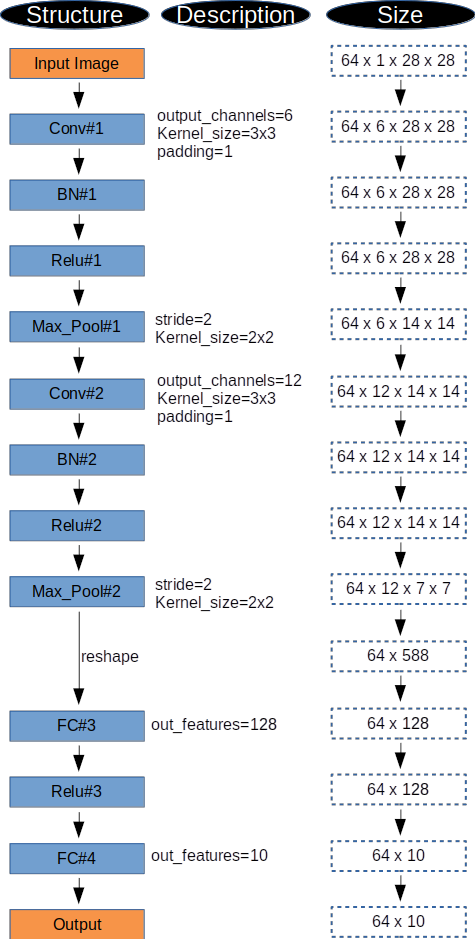

To define your own Network, following the rule of thumb:  
1. Define the layers in `__init__`.  
2. Do the forward calculation in `forward`.  
<span style="color:red"> ***Be careful that this model is a little bit different than the model in assignment 3*** </span>

### Fill in the model  (<span style="color:green">1.0 point</span>)

In [13]:
class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 

        # define layers 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # TODO: fill the rest part (0.5 points)  
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc3 = nn.Linear(588, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)     
        x = self.max_pool1(x)
        
        # TODO: fill the rest part, you may need more lines like x = ... (0.5 points)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x) 
        x = self.max_pool2(x)
        
        x = x.reshape(x.shape[0], -1)
        
        x = self.fc3(x)
        x = self.relu3(x)     
        x = self.fc4(x)
        
        return x
    

To define a replicate [**resnet-18**](https://arxiv.org/pdf/1512.03385.pdf) model with:  
+ The first conv layer take in 1-channel input.
+ The last fully connected layer output 10-classes.  
***(NOTE: use this model later in Part 3.4)***

In [14]:
class ResNet18_Fashion_MNIST(torchvision.models.ResNet):
    def __init__(self, num_classes=10):
        super(ResNet18_Fashion_MNIST, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
        # Override the "conv1" layer from the resnet-18 model
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
    def forward(self, x):
        return super(ResNet18_Fashion_MNIST, self).forward(x)

## Part 3. Train and test your CNN model (<span style="color:green">9.0 points or more</span>)
### Part 3.1. Create functions for train and evaluation
* Instantiate a network.

ResNet18_Fashion_MNIST(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

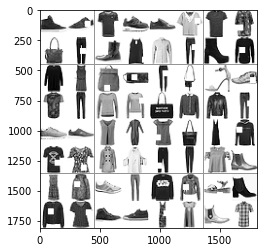

In [15]:
# Create a train writer and a validation writer
# After training, to open tensorboard run
# tensorboard --logdir tb_graphs/ --port 5656
# The above command use to run a tensorboard for data in ./tb_graphs folder in port 5656
writer = SummaryWriter('tb_graphs/training')
val_writer = SummaryWriter('tb_graphs/validation')

# Switch between models
use_resnet18 = True
if not use_resnet18:
    # instantiate a network
    net = Network(num_classes=10)
else:
    # instantiate ResNet-18 model
    net = ResNet18_Fashion_MNIST(num_classes=10)
    
# Print out the layers of our model
print(net)

# Get some random training images
_iter = iter(train_loader)
samples = _iter.next()
images = samples['image']

# Create grid of images
img_grid = torchvision.utils.make_grid(images)

# Show images
plt.imshow(img_grid.mean(dim=0).cpu().numpy(), cmap="Greys")

# Write to tensorboard
writer.add_image('train_images', img_grid)

# Write model graph to tensorboard
writer.add_graph(net, images)

### Part 3.2. Training and tensorboard log  (<span style="color:green">1.5 points</span>)

In [27]:
# evaluation function (not the same as in assignment 3)
def eval(net, loss_function, data_loader):
    net.eval()
    correct = 0.0
    num_images = 0.0
    running_loss = 0.0
    for i, sample in enumerate(data_loader):
        # TODO: fill these blanks
        images, labels = sample['image'], sample['label']
        images, labels = images.to(device),labels.to(device)
        outs = net(images)
        _, preds = outs.max(1)
        correct += preds.eq(labels).sum()
        running_loss += loss_function(outs, labels).item()
        num_images += len(labels)

    acc = correct.float() / num_images
    loss = running_loss / len(data_loader)
    return acc, loss

# training function
def train(net, train_loader, valid_loader, writer, loss_function):
    # TODO: build your SGD optimizer with learning rate=0.01, momentum=0.9, no weight decay
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay= 0) #fill the blank bracket

    # Log training process to tensorboard every 100 iterations
    log_every = 100
    # Training for 20 epochs (you can modify this)
    epoches = 20
    for epoch in range(epoches):
        start_t = time.time()
        net.train() 
        running_loss = 0.0
        running_acc = 0.0
        for i, sample in enumerate(train_loader):
            images, labels = sample['image'], sample['label']
            images, labels = images.to(device),labels.to(device)
            # TODO: fill these blanks            
            outs = net(images)
            loss = loss_function(outs, labels) 
            _, preds = outs.max(1)
            correct = preds.eq(labels).sum()
            running_acc += correct.float() / len(labels)
            
            # TODO: clear grads, back-propagation, backward propogation, update parameters
            # clear grads
            optimizer.zero_grad()
            
            # backward propogation
            loss.backward()

            # update parameters
            optimizer.step()
            net.eval()
                        
            running_loss += loss.item()
            
            
            if i % log_every == 99: 
                
                print('[Epoch/iter]: [{}/{}], loss: {:.05f}, accuracy: {:.05f}'.format(epoch, i+1, 
                           running_loss / log_every, running_acc / log_every))

                log_index = epoch * len(train_loader) + i
                # Log the training loss and accuracy
                # Example of using .add_scalar()
                # Note tag='Loss'
                writer.add_scalar('Loss', running_loss / log_every, log_index) # tag='Loss'
                # TODO: load the training accuracy using writer (0.5 points)
                # Note tag='Accuracy'
                writer.add_scalar('Accuracy', running_acc / log_every, log_index)
        
                # Log predictions
                # Example of using .add_figure()
                writer.add_figure('predictions', get_preds_figure(net, images, labels), log_index)
                running_loss = 0.0
                running_acc = 0.0

        
        # Running the validation

        acc_eval, loss_eval = eval(net, loss_function, valid_loader)
        print('Elapsed time: {:.02f} seconds, end of epoch: {}, lr: {}, val_loss: {:.05f}, val_acc: {:.05f}'.format(
            time.time()-start_t, epoch, optimizer.param_groups[0]['lr'], loss_eval, acc_eval))
        # Log the validation loss and accuracy
        # TODO: load the validation loss using val_writer (0.5 points)
        # Using val_writer will log the values to the validation writer
        val_log_index = epoch * len(valid_loader) + i
        # Note tag='Loss'
        val_writer.add_scalar('Loss', loss_eval, val_log_index) # tag='Loss'
        # TODO: load the validation accuracy using val_writer (0.5 points)
        # Note tag='Accuracy'
        val_writer.add_scalar('Accuracy', acc_eval, val_log_index)

    return net

### Part 3.3. Tensorboard visualization  (<span style="color:green">1.0 point</span>)
#### TODO: Take a picture and report your training+validation loss and accuracy curves here   

It should look something similar to this. (not exactly but similar)  

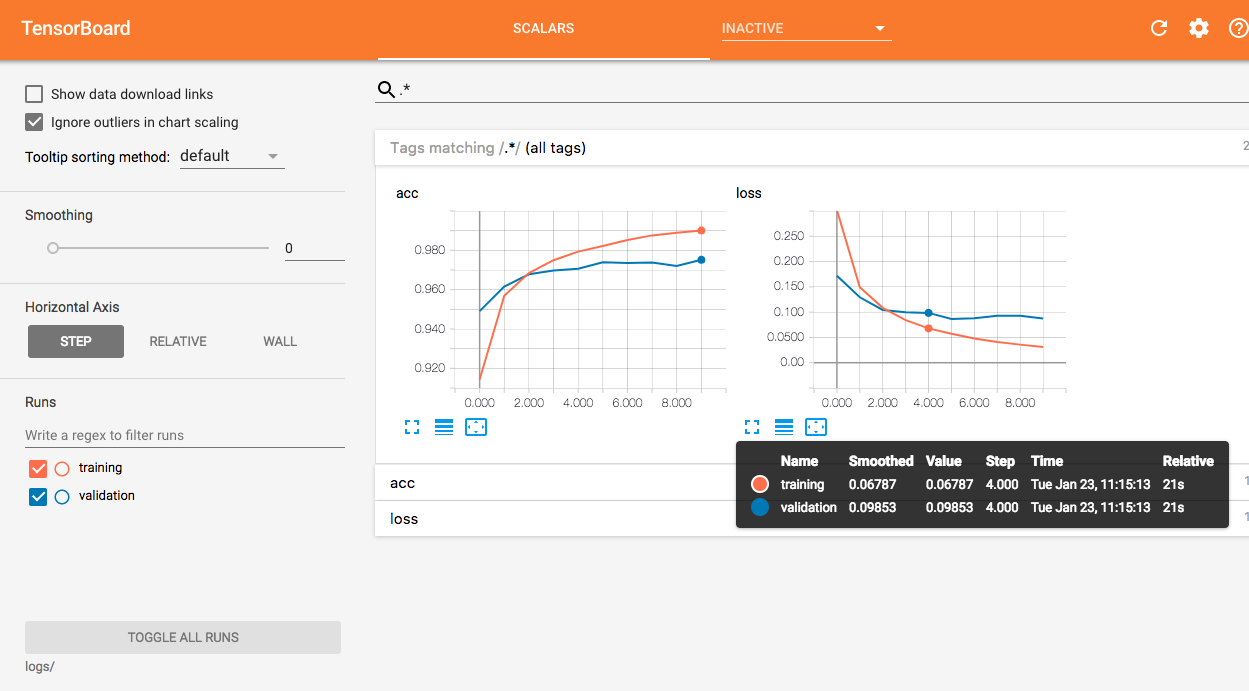


**AGAIN: after training, to open tensorboard run**
```
tensorboard --logdir tb_graphs/ --port 5656
```
The above command use to run a tensorboard for data in **./tb_graphs** folder in port **5656**



**NOTE: to add the image to this report.**
1. Take a screenshot of your tensorboard
2. Save the screenshot image
3. Drag and drop the image into this markdown cell

----->   Drag and drop the image below this line!!   <-----


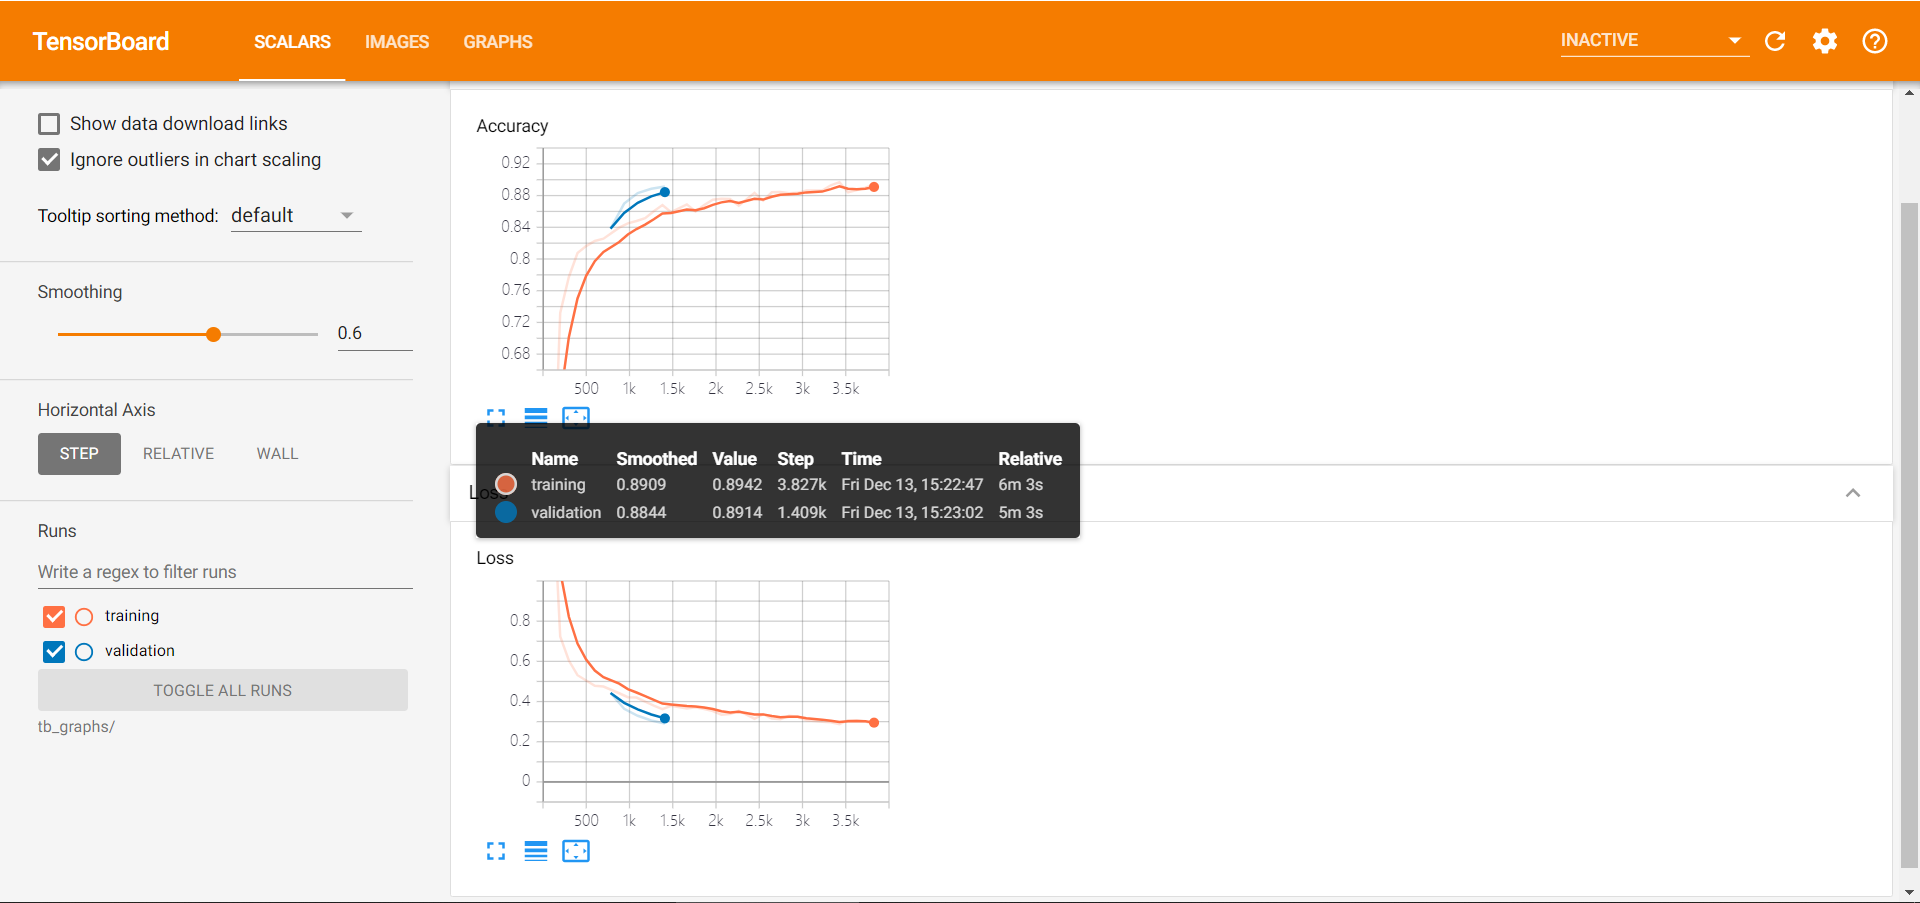

### Part 3.4. Train and test your network (<span style="color:green">1.0 point</span>)

In [28]:
print('Please wait patiently, it may take some seconds...')
# TODO: train your network here (0.5 points)
loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
    net = net.cuda()
    
train(net, train_loader, valid_loader, writer, loss_function)

# Save the weight of current model to disk
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

# Load the model weights from './net.pth'
net.load_state_dict(torch.load('./net.pth'))


if torch.cuda.is_available():
    net = net.cuda()
    
# TODO: test your network here on testing data (0.5 points)
acc_test, _ = eval(net, loss_function, test_loader)

print('Accuracy on testing data: {:.05f}'.format(acc_test))

# Close the training and validation writer
writer.close()
val_writer.close()

Please wait patiently, it may take some seconds...
[Epoch/iter]: [0/100], loss: 0.44029, accuracy: 0.84703
[Epoch/iter]: [0/200], loss: 0.38183, accuracy: 0.85812
[Epoch/iter]: [0/300], loss: 0.37352, accuracy: 0.86594
[Epoch/iter]: [0/400], loss: 0.37497, accuracy: 0.86562
[Epoch/iter]: [0/500], loss: 0.34817, accuracy: 0.86859
[Epoch/iter]: [0/600], loss: 0.36730, accuracy: 0.86531
[Epoch/iter]: [0/700], loss: 0.32522, accuracy: 0.87844
Elapsed time: 130.44 seconds, end of epoch: 0, lr: 0.01, val_loss: 0.31446, val_acc: 0.89060
[Epoch/iter]: [1/100], loss: 0.38016, accuracy: 0.87281
[Epoch/iter]: [1/200], loss: 0.31400, accuracy: 0.88641
[Epoch/iter]: [1/300], loss: 0.31497, accuracy: 0.88484
[Epoch/iter]: [1/400], loss: 0.30217, accuracy: 0.89125
[Epoch/iter]: [1/500], loss: 0.31463, accuracy: 0.88453
[Epoch/iter]: [1/600], loss: 0.29966, accuracy: 0.89250
[Epoch/iter]: [1/700], loss: 0.29817, accuracy: 0.89094
Elapsed time: 130.61 seconds, end of epoch: 1, lr: 0.01, val_loss: 0.307

[Epoch/iter]: [16/700], loss: 0.11120, accuracy: 0.95797
Elapsed time: 131.45 seconds, end of epoch: 16, lr: 0.01, val_loss: 0.23802, val_acc: 0.92240
[Epoch/iter]: [17/100], loss: 0.09435, accuracy: 0.96703
[Epoch/iter]: [17/200], loss: 0.07066, accuracy: 0.97578
[Epoch/iter]: [17/300], loss: 0.10137, accuracy: 0.96562
[Epoch/iter]: [17/400], loss: 0.09051, accuracy: 0.96484
[Epoch/iter]: [17/500], loss: 0.09607, accuracy: 0.96344
[Epoch/iter]: [17/600], loss: 0.10038, accuracy: 0.96094
[Epoch/iter]: [17/700], loss: 0.09665, accuracy: 0.96750
Elapsed time: 131.83 seconds, end of epoch: 17, lr: 0.01, val_loss: 0.23970, val_acc: 0.91940
[Epoch/iter]: [18/100], loss: 0.08207, accuracy: 0.97250
[Epoch/iter]: [18/200], loss: 0.08312, accuracy: 0.96781
[Epoch/iter]: [18/300], loss: 0.06991, accuracy: 0.97266
[Epoch/iter]: [18/400], loss: 0.09548, accuracy: 0.96562
[Epoch/iter]: [18/500], loss: 0.09011, accuracy: 0.96937
[Epoch/iter]: [18/600], loss: 0.08944, accuracy: 0.96578
[Epoch/iter]: 

### Part 3.5. Train and test using the resnet-18 model (<span style="color:green">2.5 points</span>)  
**To use the resnet-18 model, you can set:** (This model will take longer training time)
```
use_resnet18 = True
```

Remember to resize the input image from (28x28) -> (224x224) before convert it to pytorch tensor. To resize the PIL image, you can use e.g. [transform.Resize()](https://pytorch.org/docs/stable/torchvision/transforms.html)  
```
torchvision.transforms.Resize(size, interpolation=2)
```
Something for example:
```
transform=transforms.Compose([
                        RandomWindowDrop(6),
                        transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize(__normalize_stats['mean'], __normalize_stats['std'])
                            ])
```
and we have to **resize** for **training/validation/testing DataLoader**

Accuracy on testing data: 0.92790 (<span style="color:green">1.5 points</span>)

Report your training+validation loss and accuracy tensorboard curves of the resnet-18 model (<span style="color:green">1.0 point</span>)


**Anwser**

* You can find traning and validation loss and accuracy from above printing.

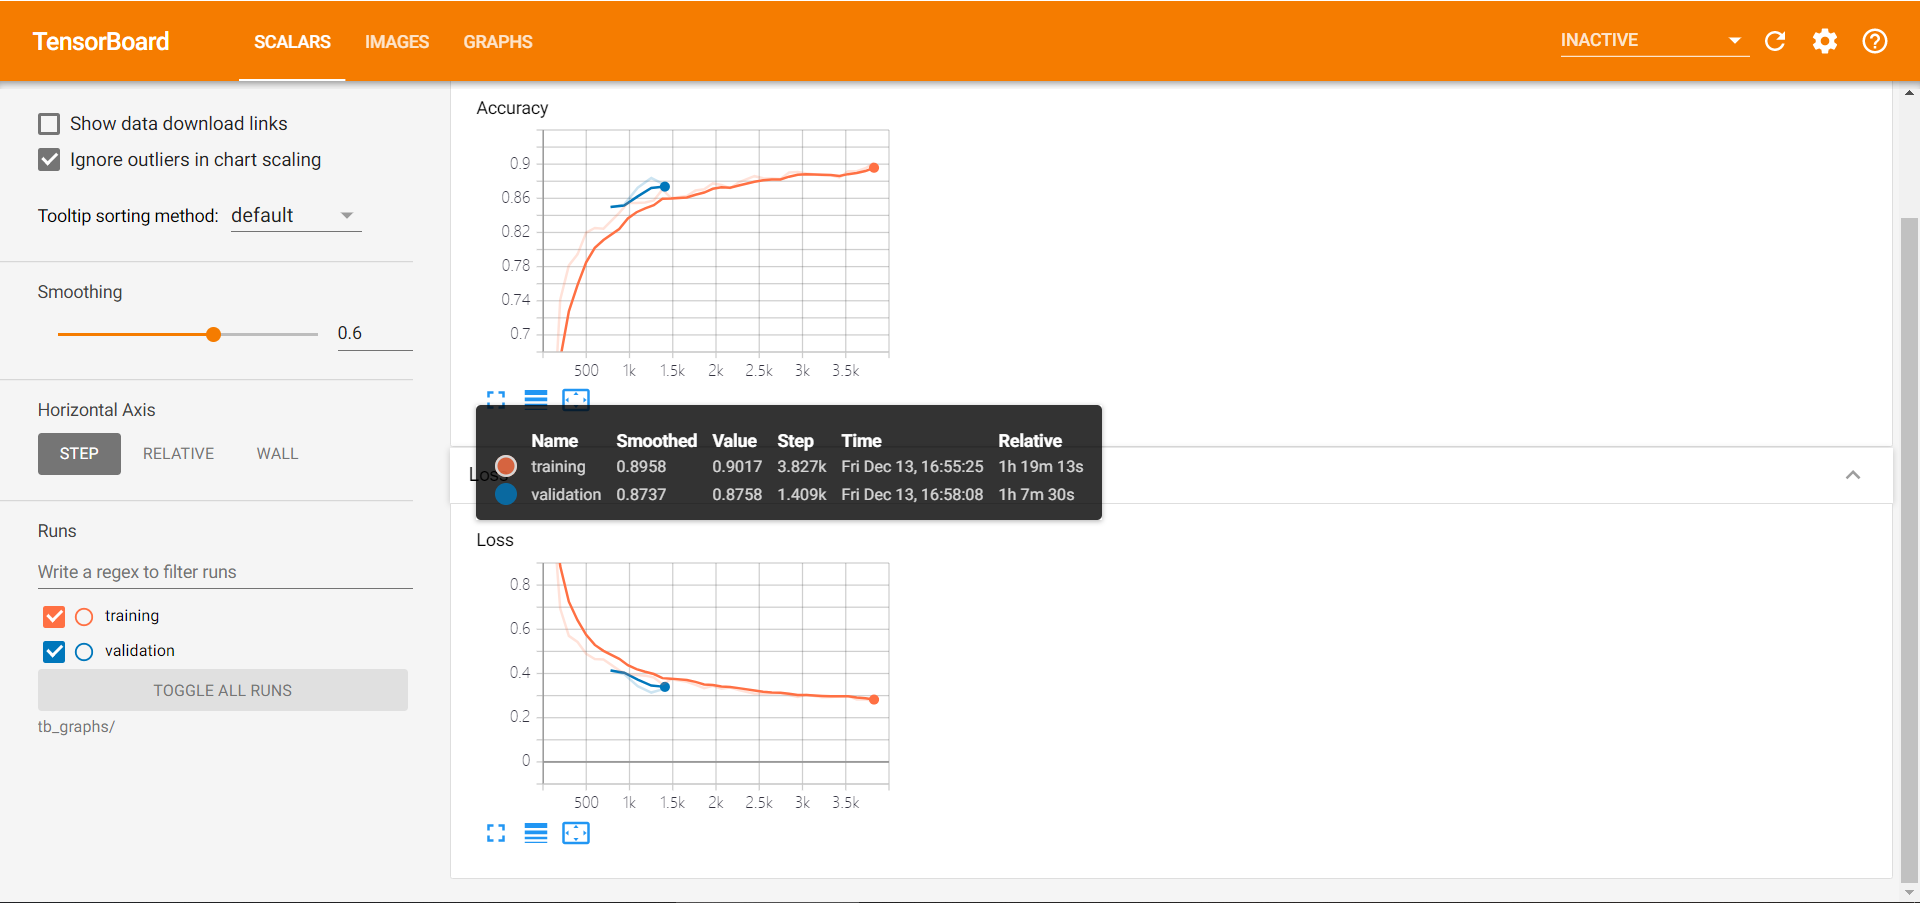

### Part 3.7. Ideas on improving the testing accuracy (<span style="color:green">max 2 points</span>)
#### Your answer: (the first two is 0.5 points each, the rest is 0.25 points each. More ideas, more points, with the upper limit 2 points in total. Ideas should be reasonable and persuasive.)

**Answer:**
* Choose a Better Batch Size
* Data Augmentation
* Generating Hard Data
* Add Regularization Terms in Loss Function, such as Weight Decay
* Find a Better Model
* Add Dropout Layer in Model